In [ ]:
import math
import geopandas as gpd
import numpy as np
import os
import pandas as pd
from shapely.geometry import Polygon, MultiPolygon

def area_ratio(gdf, jinguan_class): #斑块面积比重
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class]
    return gdf2['area'].sum() / gdf['area'].sum()

def SHDI(p1, p2, p3, p4):   #香农多样性指数
    min_p = 1e-10
    return -(p1 * math.log(max(p1, min_p)) + p2 * math.log(max(p2, min_p)) + p3 * math.log(max(p3, min_p))  + p4 * math.log(max(p4, min_p)))

def SHEI(p1, p2, p3, p4):   #香农均匀性指数
    if SHDI(p1, p2, p3, p4) == 0:
        return 1
    p = [p1, p2, p3, p4]
    S = sum(1 for item in p if item != 0)
    return SHDI(p1, p2, p3, p4) / math.log(S)

def max_index(gdf, jinguan_class): #最大斑块指数
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class]   
    if len(gdf2) == 0: return 0
    return gdf2['area'].max() / gdf['area'].sum()

def fragmentation(gdf, jinguan_class):   #破碎度
    gdf2 = gdf[gdf['CLASS_NB1ME'] == jinguan_class]    
    return (gdf2.shape[0] - 1) * gdf2['area'].min() / gdf2['area'].sum()

def density(gdf, jinguan_class): #斑块密度
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class]    
    return len(gdf2)
#     return len(gdf2) / gdf['area'].sum() * 1e6

def average_distance(gdf, jinguan_class):
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class].copy()
    if len(gdf2) == 1: return 0
    internal_points = gdf2.representative_point()
    # 将中心点添加到原始GeoDataFrame中
    gdf2['internal_point'] = internal_points
    distances = []
    # 计算所有点对之间的距离
    for i in gdf2.index:
        for j in gdf2.index:
            if i < j:  # 只计算每一对点一次，避免重复
                dist = gdf2.geometry[i].distance(gdf2.geometry[j])
                distances.append(dist)
    return (sum(distances) / math.sqrt(gdf['area'].sum())) / len(distances)
#     return sum(distances)/len(distances)

def separate(gdf, jinguan_class):  #分离度
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class].copy()
    result = 0
    for index, row in gdf2.iterrows():
        result += (row['area'] / gdf2['area'].sum()) * (row['area'] / gdf2['area'].sum())
    return 1 - result

def edge_density(gdf, jinguan_class):   #边缘密度
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class]
    gdf2 = gdf2.to_crs(epsg=4547)
    # 初始化边长总和和面积总和
    total_perimeter = 0
    total_area = 0
    # 遍历所有几何对象
    for geometry in gdf2.geometry:
        # 如果是复多边形，则分解为多个多边形
        if isinstance(geometry, MultiPolygon):
            for polygon in geometry.geoms:
                total_perimeter += polygon.length
                total_area += polygon.area
        elif isinstance(geometry, Polygon):
            total_perimeter += geometry.length
            total_area += geometry.area
    if len(gdf2) == 0: return 0
    return total_perimeter / total_area

def mediumland_area_ratio(gdf, jinguan_class):
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class]
    k = gdf['area'].sum()
    gdf3 = gdf2[gdf2['area'] > 0.05 * k]
    gdf4 = gdf3[gdf3['area'] < 0.2 * k]
    return gdf4['area'].sum() / gdf2['area'].sum()

def island_area_ratio(gdf, jinguan_class):
    gdf2 = gdf[gdf['CLASS_NAME'] == jinguan_class]
    k = gdf['area'].sum()
    gdf3 = gdf2[gdf2['area'] < 0.04 * k]
    return gdf3['area'].sum() / gdf2['area'].sum()

def translate(in_, label_class):
    if type(in_) == str:
        if  label_class == 'A':
            if in_ == '景观单一均质': return 1
            if in_ == '山林景观均质': return 2
            if in_ == '农业景观均质': return 3
            if in_ == '城镇化景观均质': return 4
            if in_ == '景观多样异质': return 5
        if  label_class == 'B1':
            if in_ == '聚落连片集中': return 1
            if in_ == '聚落分散集中': return 2
            if in_ == '聚落分散破碎': return 3 
        if  label_class == 'B2':
            if in_ == '耕地连片集中': return 1
            if in_ == '耕地分散集中': return 2
            if in_ == '耕地分散破碎': return 3 
        if  label_class == 'C':
            if in_ == '聚落团状': return 1
            if in_ == '聚落带状': return 2
            if in_ == '聚落自由状': return 3 
            if in_ == '聚落形状相似，以自由状为主': return 4
            if in_ == '聚落形状相似，以带状为主': return 5
            if in_ == '聚落形状相似，以团状为主': return 6
            if in_ == '聚落形状分异': return 7          
    else:
        if  label_class == 'A':
            if in_ == 1: return '景观单一均质'
            if in_ == 2: return '山林景观均质'
            if in_ == 3: return '农业景观均质'
            if in_ == 4: return '城镇化景观均质'
            if in_ == 5: return '景观多样异质'
        if  label_class == 'B1':
            if in_ == 1: return '聚落连片集中'
            if in_ == 2: return '聚落分散集中'
            if in_ == 3: return '聚落分散破碎'
        if  label_class == 'B2':
            if in_ == 1: return '耕地连片集中'
            if in_ == 2: return '耕地分散集中'
            if in_ == 3: return '耕地分散破碎'
        if  label_class == 'C':
            if in_ == 1: return '聚落团状'
            if in_ == 2: return '聚落带状'
            if in_ == 3: return '聚落自由状'
            if in_ == 4: return '聚落形状相似，以自由状为主'
            if in_ == 5: return '聚落形状相似，以带状为主'
            if in_ == 6: return '聚落形状相似，以团状为主'
            if in_ == 7: return '聚落形状分异'
        
def get_label_value(row, label_class, k):           # eweewewew
    if pd.notnull(row['real' + label_class]):
        label_vlaue = row['real' + label_class]
    else:
        # 使用mode()方法，并处理多个模式的情况（如果有并列最多的元素，只取第一个）
        label_vlaue = row[['tester1' + label_class, 'tester2' + label_class, 'tester3' + label_class, 'tester4' + label_class]].mode()[0]
    if row['tester1' + label_class] == label_vlaue: k += 1
    if row['tester2' + label_class] == label_vlaue: k += 1
    if row['tester3' + label_class] == label_vlaue: k += 1
    if row['tester4' + label_class] == label_vlaue: k += 1
    return translate(label_vlaue, label_class), k


from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn
import torch.optim as optim

# 定义MLP模型
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

    
def cal(train_X, train_y, test_X, test_y, get_model = False):    
    # 训练模型
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(train_X, train_y)
    #预测
    prediction_label1 = decision_tree.predict(test_X)
    accuracy1 = np.count_nonzero(prediction_label1 == test_y) / len(test_y)
#     print(f'Test Accuracy1: {accuracy1:.4f}')
    

    # 训练模型
    svc = SVC(kernel='linear')  # 使用线性核
    svc.fit(train_X, train_y)
    #预测
    prediction_label2 = svc.predict(test_X)
    accuracy2 = np.count_nonzero(prediction_label2 == test_y) / len(test_y)
#     print(f'Test Accuracy2: {accuracy2:.4f}')

    
    
    # 训练模型
    logistic_regression = LogisticRegression(max_iter = 10000)
    logistic_regression.fit(train_X, train_y)
    #预测
    prediction_label3 = logistic_regression.predict(test_X)
    accuracy3 = np.count_nonzero(prediction_label3 == test_y) / len(test_y)
#     print(f'Test Accuracy3: {accuracy3:.4f}')



    # 训练模型
    random_forest = RandomForestClassifier(n_estimators=100, random_state=42)  # 100棵树
    random_forest.fit(train_X, train_y)
    #预测
    prediction_label4 = random_forest.predict(test_X)
    accuracy4 = np.count_nonzero(prediction_label4 == test_y) / len(test_y)

    # # 获取特征重要性
    # importances = random_forest.feature_importances_
    # column_names = ['cmbh', 'Label_A', 'Label_B1', 'Label_B2', 'Label_C（无效）']
    # column_names += ['p1（建设用地的面积占比）', 'p2（耕地的面积占比）', 'p3（林地的面积占比）', 'p4（草地的面积占比）']
    # column_names += ['m1（建设用地的最大斑块指数）', 'm2（耕地的最大斑块指数）', 'm3（林地的最大斑块指数）', 'm4（草地的最大斑块指数）']
    # column_names += ['SHDI（香农多样性指数）', 'SHEI（香农均匀性指数）']
    # column_names += ['den1（建设用地的斑块数量）', 'medland1（中型建筑用地斑块的面积占比）', 'island1（小型建设用地斑块的面积占比）', 'sep1（建设用地的分离度）']
    # column_names += ['den2（耕地的斑块数量）', 'medland2（中型耕地斑块的面积占比）', 'island1（小型耕地斑块的面积占比）', 'sep1（耕地的分离度）']
    # column_names += ['水域的面积占比', '水域的最大斑块指数']
    # column_names += ['林地的分离度', '草地的分离度', '水域的分离度']
    # column_names += ['建设用地的边缘密度', '耕地的边缘密度', '林地的边缘密度', '草地的边缘密度', '水域的边缘密度']
    # feature_names = []
    # for i in [6, 19, 20, 21, 22]: feature_names.append(column_names[i])
    # feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    # if not os.path.isfile('out.xlsx'):
    #     # 创建一个空的DataFrame，并写入Excel文件，以创建文件
    #     feature_importances_df.to_excel('out.xlsx',sheet_name='labelB2', index=False)
    # with pd.ExcelWriter('out.xlsx', engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
    #     feature_importances_df.to_excel(writer, sheet_name='lableB2', index=False)
# unlabeled_X_A = all_unlabeled_informations[:,[5, 6, 7, 9, 10, 11, 13, 14]].copy()
# unlabeled_X_B1 = all_unlabeled_informations[:,[5, 15, 16, 17, 18]].copy()
# unlabeled_X_B2 = all_unlabeled_informations[:,[6, 19, 20, 21, 22]].copy()


    # 设置模型参数
    input_size = train_X.shape[1]
    hidden_size = 8
    output_size = int(train_y.max())  # 五分类问题

    # 创建模型实例
    model = SimpleMLP(input_size, hidden_size, output_size)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    # 假设data是您的二维numpy数组
    # 将numpy数组转换为pytorch张量
    train_X_tensor = torch.tensor(train_X, dtype=torch.float32)
    # 对于多分类问题，标签需要转换为整数索引
    train_y_tensor = torch.tensor(train_y - 1, dtype=torch.long)

    # 训练模型
    num_epochs = 3000
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_X_tensor)
        loss = criterion(outputs, train_y_tensor)
        loss.backward()
        optimizer.step()

#         if (epoch+1) % 3000 == 0:
#             print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)
    test_y_tensor = torch.tensor(test_y - 1, dtype=torch.long)

    # 将模型设置为评估模式
    model.eval()

    # 禁用梯度计算，以减少计算量
    with torch.no_grad():
        # 对测试集进行预测
        outputs_test = model(test_X_tensor)
        # 获取预测结果的最大值所在的位置，即预测的类别
        prediction_label5_tensor = outputs_test.argmax(dim=1)

    # 计算正确率
    accuracy5 = (prediction_label5_tensor == test_y_tensor).float().mean()
    accuracy5 = accuracy5.item()
#     print(f'Test Accuracy5: {accuracy5:.4f}')

    prediction_labels = np.vstack((prediction_label1, prediction_label2, prediction_label3, prediction_label4, prediction_label5_tensor.numpy() + 1)).T

    # 使用Pandas的mode函数来找到每列中出现次数最多的值
    super_prediction_label = (pd.DataFrame(prediction_labels).mode(axis=1)[0]).values
    accuracy6 = np.count_nonzero(super_prediction_label == test_y) / len(test_y) 
#     print(f'Test Accuracy6: {accuracy6:.4f}')


    k1 = 0
    index = np.where((super_prediction_label == test_y) == False)[0]
    for i in range(0, prediction_labels.shape[0]):
        _, counts = np.unique(prediction_labels[i], return_counts=True)
        if counts.max() > 3: k1+=1
#     print(prediction_labels.shape[0], k1)

    k2 = 0
    for i in index:
        _, counts = np.unique(prediction_labels[i], return_counts=True)
        if counts.max() > 3: k2+=1
#     print(len(index), k2)
    accuracy7 = ((k1 - k2) / k1)
#     print(f'Test Accuracy7: {accuracy7:.4f}')
    if get_model: 
        print(accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6, accuracy7)
        return decision_tree, svc, logistic_regression, random_forest, model
    return accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6, accuracy7




import re

def str_to_list(s):
    s = str(s)
    # 使用正则表达式找到所有的数字
    numbers = re.findall(r'\d+', s.replace('，', ','))
    # 将字符串数字转换为整数列表
    numbers_list = [int(num) for num in numbers]
    return numbers_list[1:]

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # 减去每行的最大值以防止溢出
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


def diffsion(all_unlabeled_informations, all_edges):
    k = 0
    pointer = 0
    diff_values = np.zeros((0, 10))
    for area_id, area in enumerate(excel_areas):
        all_edge = all_edges[area_id]
        all_unlabeled_information = all_unlabeled_informations[pointer:pointer + len(all_edge)]
        pointer += len(all_edge)
        diff_value = np.zeros((all_unlabeled_information.shape[0], 10))
        for i in range(0, all_unlabeled_information.shape[0]):
            current_information = all_unlabeled_information[i]
            for nearby_cmbh in all_edge[current_information[0]]:
                if all_unlabeled_information[all_unlabeled_information[:,0] == nearby_cmbh].shape[0] != 1: continue
                if nearby_cmbh == current_information[0]: continue
                nearby_information = all_unlabeled_information[all_unlabeled_information[:,0] == nearby_cmbh][0]
                if  np.sum(abs(nearby_information[5:9] - current_information[5:9])) < 0.2:
                    k += 1
                    diff_value[all_unlabeled_information[:,0] == nearby_cmbh] += current_information[5:15] * -0.1
                    diff_value[i] += nearby_information[5:15] * 0.1
        diff_values = np.vstack((diff_values, diff_value))
    print('扩散次数：',k)
    all_unlabeled_informations[:,5:15] += diff_values
    return all_unlabeled_informations


def get_label(test_X, model1, model2, model3, model4, model5, get_all = False):
    prediction_label1 = model1.predict(test_X)  
    prediction_label2 = model2.predict(test_X)  
    prediction_label3 = model3.predict(test_X)  
    prediction_label4 = model4.predict(test_X)
    test_X_tensor = torch.tensor(test_X, dtype=torch.float32)    
    with torch.no_grad():
        # 对测试集进行预测
        outputs_test = model5(test_X_tensor)
        # 获取预测结果的最大值所在的位置，即预测的类别
        prediction_label5_tensor = outputs_test.argmax(dim=1)

    prediction_label5 = prediction_label5_tensor.numpy() + 1
    prediction_labels = np.vstack((prediction_label1, prediction_label2, prediction_label3, prediction_label4, prediction_label5)).T
    
    # 使用Pandas的mode函数来找到每列中出现次数最多的值
    super_prediction_label = (pd.DataFrame(prediction_labels).mode(axis=1)[0]).values
    if not get_all: return super_prediction_label
    return prediction_label1, prediction_label2, prediction_label3, prediction_label4, prediction_label5, super_prediction_label


import xgboost as xgb
from sklearn.metrics import accuracy_score
def cal_xgb(train_X, train_y, test_X, test_y, get_model = False):
    dtrain = xgb.DMatrix(train_X, label=train_y - 1)
    dtest = xgb.DMatrix(test_X, label=test_y - 1)
    params = {
        'max_depth': 3,         # 树的最大深度
        'eta': 0.1,             # 学习率
        'objective': 'binary:logistic' if len(np.unique(train_y)) == 2 else 'multi:softmax',  # 目标函数
        'num_class': len(np.unique(train_y))  # 类别数量，仅对多分类问题有效
    }
    num_round = 100  # 迭代次数
    bst = xgb.train(params, dtrain, num_round)
    preds = bst.predict(dtest)
    pred_labels = preds + 1
    accuracy = accuracy_score(test_y, pred_labels)
    if get_model: return bst
    return accuracy

def get_label_xgb(test_X, bst):
    dtest = xgb.DMatrix(test_X)
    preds = bst.predict(dtest)
    pred_labels = preds + 1
    return pred_labels


In [5]:
# 定义Excel文件名
excel_files = ['tester1', 'tester2', 'tester3', 'tester4']
excel_areas = ['常州','杭州', '湖州', '嘉兴', '上海','苏州','无锡','镇江']
label_classes = ['A', 'B1', 'B2', 'C']

#定义一些数据
all_labeled_informations = np.zeros((0, 24))
k1 = 0                                              #记录下人工正确率
k2 = 0
k3 = 0
k4 = 0
all_unlabeled_informations = np.zeros((0, 24 + 10))
all_edges = []

for area_id, area in enumerate(excel_areas):
    # 读取Excel文件并存储在字典中
    dataframes = []
    for file in excel_files:
        df = pd.read_excel('C:/Users/44156/Desktop/科研项目/空间基因/data_label/' + area + '/' + area + file + '.xlsx', usecols=[0, 1 ,2 ,3, 4])
        # 假设样本编号列的名称是 'SampleID'，标签列的名称是 'tester'
        df.columns = ['SampleID', file +'A', file +'B1', file +'B2', file +'C']
        dataframes.append(df)
       
    for label_class in label_classes:
        df = pd.read_excel('C:/Users/44156/Desktop/科研项目/空间基因/data_label/修正标签0624/' + label_class + '.xlsx', sheet_name=area,  usecols=[0, 7])
        df.columns = ['SampleID', 'real' + label_class]
        dataframes.append(df)
    # 合并所有DataFrame
    merged_df = dataframes[0].copy()
    for dataframe in dataframes[1:]:
        merged_df = merged_df.merge(dataframe, on='SampleID', how='outer')
    unique_values = merged_df['SampleID'].unique()
    
    
    all_labeled_information = np.zeros((len(merged_df), 24))   
                               
    # 设定用地的目录路径
    directory_path ='C:/Users/44156/Desktop/科研项目/空间基因/data/' + area +'用地'
    # 列出目录下所有的文件
    file_list = os.listdir(directory_path)
    # 筛选出所有的.shp文件
    shp_files = [f for f in file_list if f.endswith('.shp')]
    # 检查是否只有一个.shp文件
    if len(shp_files) == 1:
        # 获取唯一的.shp文件名
        shp_file = shp_files[0]
        # 读取.shp文件
        gdf_xc = gpd.read_file(directory_path + '/' + shp_file)
        gdf_xc = gdf_xc[gdf_xc['CLASS_NAME'].isin(['林地','耕地' ,'草地', '建设用地', '水域'])]
    else:
        print("没有找到唯一的.shp文件，或者找到了多个.shp文件。跳过该地区：" + area)  
        break
     
    # 设定村落的目录路径
    directory_path ='C:/Users/44156/Desktop/科研项目/空间基因/data/' + area +'村落'
    # 列出目录下所有的文件
    file_list = os.listdir(directory_path)
    # 筛选出所有的.shp文件
    shp_files = [f for f in file_list if f.endswith('.shp')]
    # 检查是否只有一个.shp文件
    if len(shp_files) == 1:
        # 获取唯一的.shp文件名
        shp_file = shp_files[0]
        # 读取.shp文件
        gdf_cunluo = gpd.read_file(directory_path + '/' + shp_file)
    else:
        print("没有找到唯一的.shp文件，或者找到了多个.shp文件。跳过该地区：" + area)  
        break
    
    for index, row in merged_df.iterrows():
        all_labeled_information[index][0] = row['SampleID']           
        gdf_xc_filtered = gdf_xc[gdf_xc['cmbh'] == row['SampleID']]
        all_labeled_information[index][1], k1 = get_label_value(row, 'A', k1)
        all_labeled_information[index][2], k2 = get_label_value(row, 'B1', k2)
        all_labeled_information[index][3], k3 = get_label_value(row, 'B2', k3)
        all_labeled_information[index][4], k4 = get_label_value(row, 'C', k4)
        p1 = area_ratio(gdf_xc_filtered, '建设用地')
        p2 = area_ratio(gdf_xc_filtered, '耕地')
        p3 = area_ratio(gdf_xc_filtered, '林地')
        p4 = area_ratio(gdf_xc_filtered, '草地')
        all_labeled_information[index][5] = p1
        all_labeled_information[index][6] = p2
        all_labeled_information[index][7] = p3
        all_labeled_information[index][8] = p4
        all_labeled_information[index][9] = max_index(gdf_xc_filtered, '建设用地')
        all_labeled_information[index][10] = max_index(gdf_xc_filtered, '耕地')
        all_labeled_information[index][11] = max_index(gdf_xc_filtered, '林地')
        all_labeled_information[index][12] = max_index(gdf_xc_filtered,  '草地')
        SH = SHDI(p1, p2, p3, p4)
        all_labeled_information[index][13] = SH
        SH = SHEI(p1, p2, p3, p4)
        all_labeled_information[index][14] = SH
        if len(gdf_xc_filtered[gdf_xc_filtered['CLASS_NAME'] == '建设用地']) == 0:
            d1 = 0
            m1 = 0
            i1 = 0
            s1 = 0
        else:
            d1 = density(gdf_xc_filtered, '建设用地')
            m1 = mediumland_area_ratio(gdf_xc_filtered, '建设用地')
            i1 = island_area_ratio(gdf_xc_filtered, '建设用地')
            s1 = separate(gdf_xc_filtered, '建设用地')
        if len(gdf_xc_filtered[gdf_xc_filtered['CLASS_NAME'] == '耕地']) == 0:
            d2 = 0
            m2 = 0
            i2 = 0
            s2 = 0
        else:
            d2 = density(gdf_xc_filtered, '耕地')
            m2 = mediumland_area_ratio(gdf_xc_filtered, '耕地')
            i2 = island_area_ratio(gdf_xc_filtered, '耕地')
            s2 = separate(gdf_xc_filtered, '耕地')
        all_labeled_information[index][15] = d1
        all_labeled_information[index][16] = m1
        all_labeled_information[index][17] = i1
        all_labeled_information[index][18] = s1
        all_labeled_information[index][19] = d2
        all_labeled_information[index][20] = m2
        all_labeled_information[index][21] = i2
        all_labeled_information[index][22] = s2
        all_labeled_information[index][23] = area_id
    
    unique_values = gdf_xc['cmbh'].unique()
    all_unlabeled_information = np.zeros((len(unique_values), 24 + 10))
    all_edge = {}
    for index, cmbh in enumerate(unique_values):
        all_edge[cmbh] = str_to_list(gdf_cunluo[gdf_cunluo['cmbh'] == cmbh]['相邻cmbh'])
        
        gdf_xc_filtered = gdf_xc[gdf_xc['cmbh'] == cmbh]
        all_unlabeled_information[index][0] = cmbh
        all_unlabeled_information[index][1] = 0
        all_unlabeled_information[index][2] = 0
        all_unlabeled_information[index][3] = 0
        all_unlabeled_information[index][4] = 0
        p1 = area_ratio(gdf_xc_filtered, '建设用地')
        p2 = area_ratio(gdf_xc_filtered, '耕地')
        p3 = area_ratio(gdf_xc_filtered, '林地')
        p4 = area_ratio(gdf_xc_filtered, '草地')
        all_unlabeled_information[index][5] = p1
        all_unlabeled_information[index][6] = p2
        all_unlabeled_information[index][7] = p3
        all_unlabeled_information[index][8] = p4
        all_unlabeled_information[index][9] = max_index(gdf_xc_filtered, '建设用地')
        all_unlabeled_information[index][10] = max_index(gdf_xc_filtered, '耕地')
        all_unlabeled_information[index][11] = max_index(gdf_xc_filtered, '林地')
        all_unlabeled_information[index][12] = max_index(gdf_xc_filtered,  '草地')
        SH = SHDI(p1, p2, p3, p4)
        all_unlabeled_information[index][13] = SH
        SH = SHEI(p1, p2, p3, p4)
        all_unlabeled_information[index][14] = SH
        if len(gdf_xc_filtered[gdf_xc_filtered['CLASS_NAME'] == '建设用地']) == 0:
            d1 = 0
            m1 = 0
            i1 = 0
            s1 = 0
        else:
            d1 = density(gdf_xc_filtered, '建设用地')
            m1 = mediumland_area_ratio(gdf_xc_filtered, '建设用地')
            i1 = island_area_ratio(gdf_xc_filtered, '建设用地')
            s1 = separate(gdf_xc_filtered, '建设用地')
        if len(gdf_xc_filtered[gdf_xc_filtered['CLASS_NAME'] == '耕地']) == 0:
            d2 = 0
            m2 = 0
            i2 = 0
            s2 = 0
        else:
            d2 = density(gdf_xc_filtered, '耕地')
            m2 = mediumland_area_ratio(gdf_xc_filtered, '耕地')
            i2 = island_area_ratio(gdf_xc_filtered, '耕地')
            s2 = separate(gdf_xc_filtered, '耕地')
        all_unlabeled_information[index][15] = d1
        all_unlabeled_information[index][16] = m1
        all_unlabeled_information[index][17] = i1
        all_unlabeled_information[index][18] = s1
        all_unlabeled_information[index][19] = d2
        all_unlabeled_information[index][20] = m2
        all_unlabeled_information[index][21] = i2
        all_unlabeled_information[index][22] = s2
        all_unlabeled_information[index][23] = area_id

        ## 额外的指标，
        all_unlabeled_information[index][24] = area_ratio(gdf_xc_filtered, '水域')
        all_unlabeled_information[index][25] = max_index(gdf_xc_filtered, '水域')
        all_unlabeled_information[index][26] = separate(gdf_xc_filtered, '林地')
        all_unlabeled_information[index][27] = separate(gdf_xc_filtered, '草地')
        all_unlabeled_information[index][28] = separate(gdf_xc_filtered, '水域')
        all_unlabeled_information[index][29] = edge_density(gdf_xc_filtered, '建设用地')
        all_unlabeled_information[index][30] = edge_density(gdf_xc_filtered, '耕地')
        all_unlabeled_information[index][31] = edge_density(gdf_xc_filtered, '林地')
        all_unlabeled_information[index][32] = edge_density(gdf_xc_filtered, '草地')
        all_unlabeled_information[index][33] = edge_density(gdf_xc_filtered, '水域')       

    all_labeled_informations = np.vstack((all_labeled_informations, all_labeled_information))
    all_unlabeled_informations = np.vstack((all_unlabeled_informations, all_unlabeled_information))
    all_edges.append(all_edge)
    print(all_labeled_informations.shape, all_unlabeled_informations.shape)
print(k1 / all_labeled_informations.shape[0] / 4, k2 / all_labeled_informations.shape[0] / 4, k3 / all_labeled_informations.shape[0] / 4)
        
                                                                                   
                                                                                   
                                                                                   

(63, 24) (1058, 34)


c:\Users\44156\anaconda3\envs\deeplearn\lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:/Users/44156/Desktop/科研项目/空间基因/data/杭州村落/杭州村筛选0606-2.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


(83, 24) (1696, 34)
(173, 24) (2898, 34)
(246, 24) (4060, 34)
(299, 24) (9345, 34)
(376, 24) (11377, 34)
(437, 24) (12532, 34)
(483, 24) (13258, 34)
0.8219461697722568 0.7883022774327122 0.7013457556935818


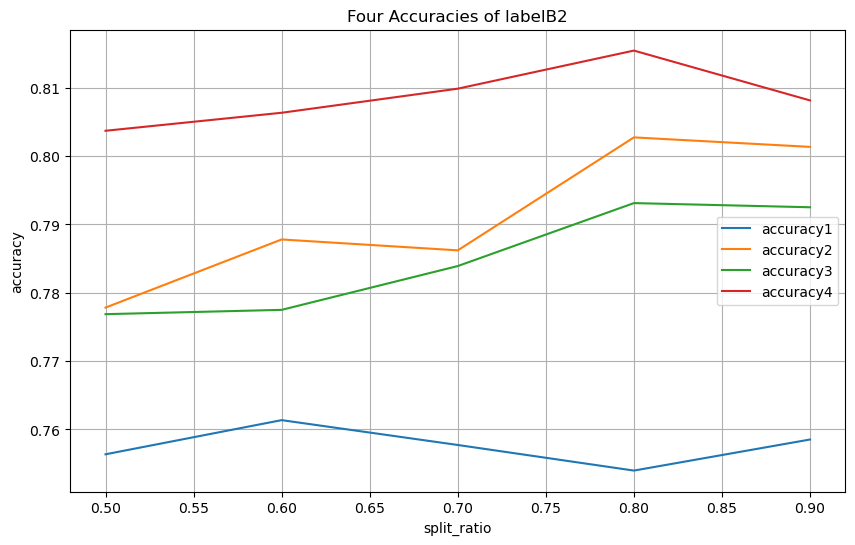

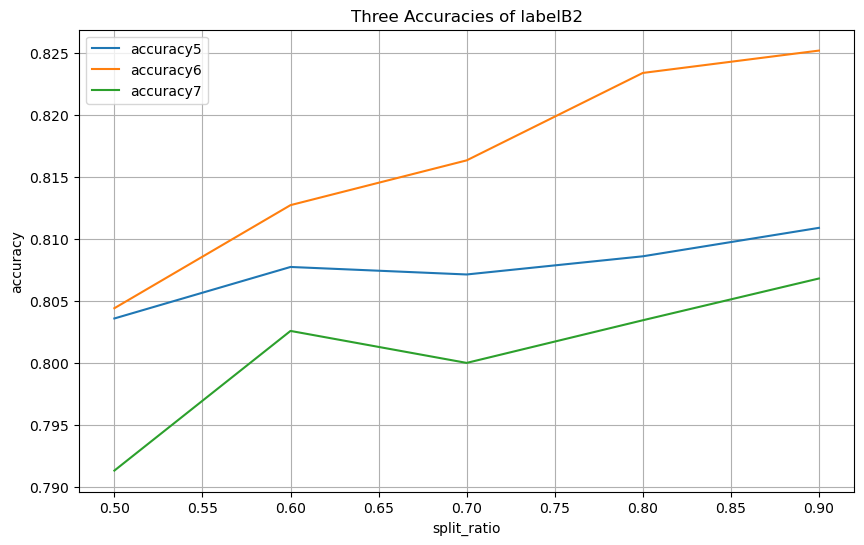

+-----------+----------------------+----------------------+----------------------+----------------------+----------------------+
|           |   split ratio = 0.50 |   split ratio = 0.60 |   split ratio = 0.70 |   split ratio = 0.80 |   split ratio = 0.90 |
+===========+======================+======================+======================+======================+======================+
| accuracy1 |                0.756 |                0.761 |                0.758 |                0.754 |                0.759 |
+-----------+----------------------+----------------------+----------------------+----------------------+----------------------+
| accuracy2 |                0.778 |                0.788 |                0.786 |                0.803 |                0.801 |
+-----------+----------------------+----------------------+----------------------+----------------------+----------------------+
| accuracy3 |                0.777 |                0.777 |                0.784 |               

In [20]:
#画准确率
from tabulate import tabulate
from matplotlib.table import Table
import matplotlib.pyplot as plt

split_ratios = np.arange(0.5, 1.0, 0.1)
all_accuracys = []
for split_ratio in split_ratios:
    total_accuracy1 = 0
    total_accuracy2 = 0
    total_accuracy3 = 0
    total_accuracy4 = 0
    total_accuracy5 = 0
    total_accuracy6 = 0
    total_accuracy7 = 0
    for i in range(0, 30):
        # 打乱数组的行
        np.random.shuffle(all_labeled_informations)

        # 计算分割点
        split_index = int(all_labeled_informations.shape[0] * split_ratio)

        # 分割数组
        part1 = all_labeled_informations[:split_index].copy()
        part2 = all_labeled_informations[split_index:].copy()

        train_X_A = part1[:,[5, 6, 7, 9, 10, 11, 13, 14]]
        train_y_A = part1[:,1]
        train_X_B1 = part1[:,[5, 15, 16, 17, 18]]
        train_y_B1 = part1[:,2]
        train_X_B2 = part1[:,[6, 19, 20, 21, 22]]
        train_y_B2 = part1[:,3]

        test_X_A = part2[:,[5, 6, 7, 9, 10, 11, 13, 14]]
        test_y_A = part2[:,1]
        test_X_B1 = part2[:,[5, 15, 16, 17, 18]]
        test_y_B1 = part2[:,2]
        test_X_B2 = part2[:,[6, 19, 20, 21, 22]]
        test_y_B2 = part2[:,3]

        j = 2
        if j == 0:
            train_X, train_y, test_X, test_y = train_X_A, train_y_A, test_X_A, test_y_A
            lablename = 'labelA'
        elif j == 1:
            train_X, train_y, test_X, test_y = train_X_B1, train_y_B1, test_X_B1, test_y_B1
            lablename = 'labelB1'
        else:
            train_X, train_y, test_X, test_y = train_X_B2, train_y_B2, test_X_B2, test_y_B2
            lablename = 'labelB2'

        accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6, accuracy7 = cal(train_X, train_y, test_X, test_y, False)
        accuracy4, accuracy5 = accuracy5, accuracy4
        accuracy7 = cal_xgb(train_X, train_y, test_X, test_y, False)
        total_accuracy1 += accuracy1
        total_accuracy2 += accuracy2
        total_accuracy3 += accuracy3
        total_accuracy4 += accuracy4
        total_accuracy5 += accuracy5
        total_accuracy6 += accuracy6
        total_accuracy7 += accuracy7
    all_accuracy = [total_accuracy1 / (i + 1), total_accuracy2 / (i + 1), total_accuracy3 / (i + 1), total_accuracy4 / (i + 1), total_accuracy5 / (i + 1), total_accuracy6 / (i + 1), total_accuracy7 / (i + 1)]
    all_accuracys.append(all_accuracy)

# 转置列表，使得每个折线的y值都在同一个列表中
all_accuracys = np.array(all_accuracys).T

# 绘制折线图
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(split_ratios, all_accuracys[i], label=f'accuracy{i+1}')
    # for j, (x, y) in enumerate(zip(split_ratios, all_accuracys[i])):
    #     plt.text(x, y, f'{y:.3f}', ha='right', va='bottom')  # 在每个点旁边显示accuracy值

plt.xlabel('split_ratio')
plt.ylabel('accuracy')
plt.title('Four Accuracies of ' + lablename)
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for i in range(4,7):
    plt.plot(split_ratios, all_accuracys[i], label=f'accuracy{i+1}')
    # for j, (x, y) in enumerate(zip(split_ratios, all_accuracys[i])):
    #     plt.text(x, y, f'{y:.3f}', ha='right', va='bottom')  # 在每个点旁边显示accuracy值

plt.xlabel('split_ratio')
plt.ylabel('accuracy')
plt.title('Three Accuracies of ' + lablename)
plt.legend()
plt.grid(True)
plt.show()


column_names = ['split ratio = 0.50', 'split ratio = 0.60', 'split ratio = 0.70', 'split ratio = 0.80', 'split ratio = 0.90']
row_names = ['', 'accuracy1', 'accuracy2', 'accuracy3', 'accuracy4', 'accuracy5', 'accuracy6', 'accuracy7']
data_with_row_names = [row_names] + list(zip(*[column_names] + np.round(all_accuracys, 3).tolist()))
data_with_row_names = list(zip(*data_with_row_names))
# 使用tabulate打印表格
print(tabulate(data_with_row_names, headers='firstrow', tablefmt='grid'))


print(all_accuracys)
with pd.ExcelWriter('out.xlsx', engine='openpyxl', mode='a', if_sheet_exists='overlay') as writer:
    column_names = ['split ratio = 0.50', 'split ratio = 0.60', 'split ratio = 0.70', 'split ratio = 0.80', 'split ratio = 0.90']
    output_indicators = pd.DataFrame(all_accuracys, columns=column_names)
    output_indicators.to_excel(writer, sheet_name=lablename, index=False)


0.8758620689655172 0.8275862068965517 0.8482758620689655 0.9172413793103448 0.931034505367279 0.9172413793103448 0.9302325581395349


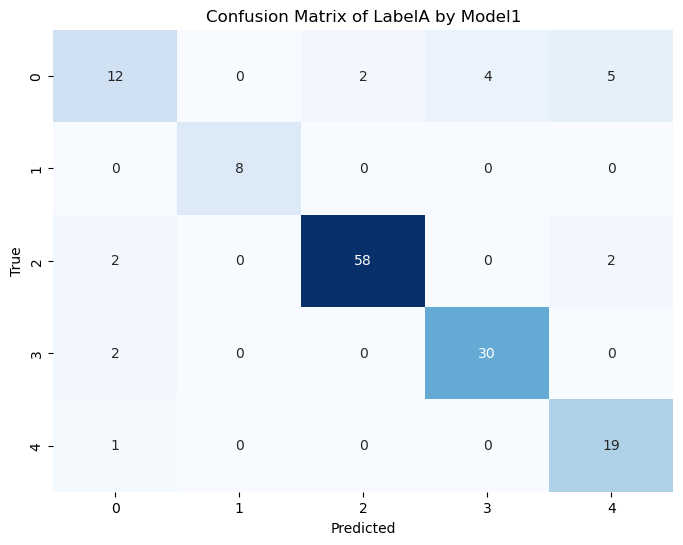

[[0.87586207 0.85713424 0.8689446  0.85719951]]


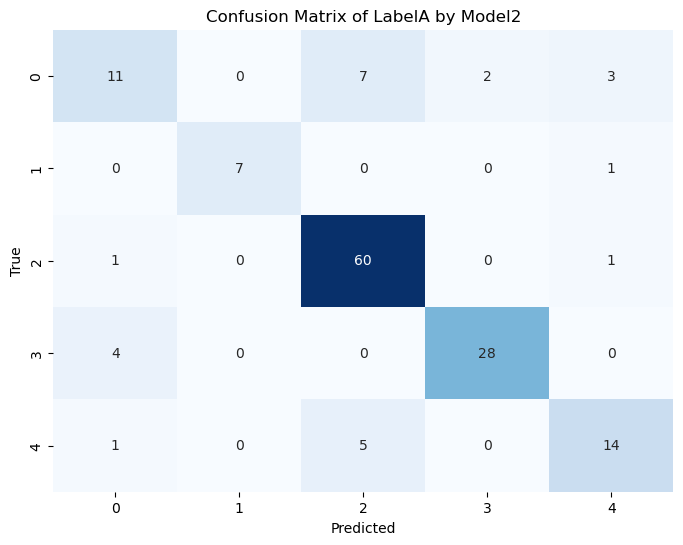

[[0.87586207 0.85713424 0.8689446  0.85719951]
 [0.82758621 0.83011352 0.77920056 0.80000605]]


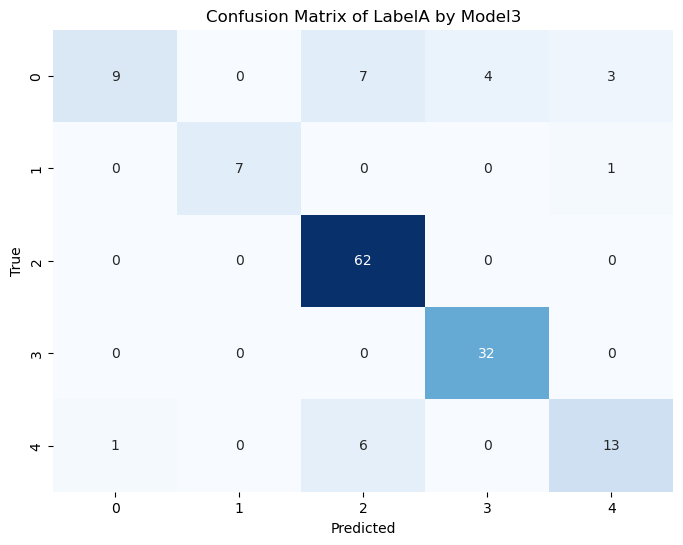

[[0.87586207 0.85713424 0.8689446  0.85719951]
 [0.82758621 0.83011352 0.77920056 0.80000605]
 [0.84827586 0.87605229 0.78326087 0.80555531]]


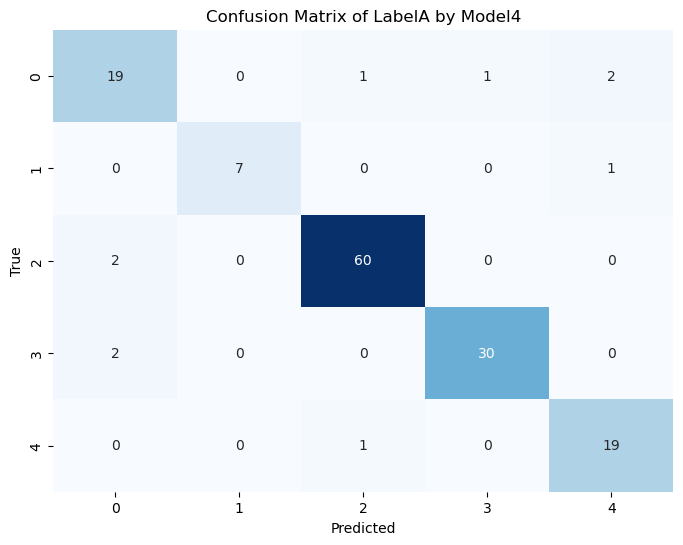

[[0.87586207 0.85713424 0.8689446  0.85719951]
 [0.82758621 0.83011352 0.77920056 0.80000605]
 [0.84827586 0.87605229 0.78326087 0.80555531]
 [0.93103448 0.92504144 0.91126578 0.91686102]]


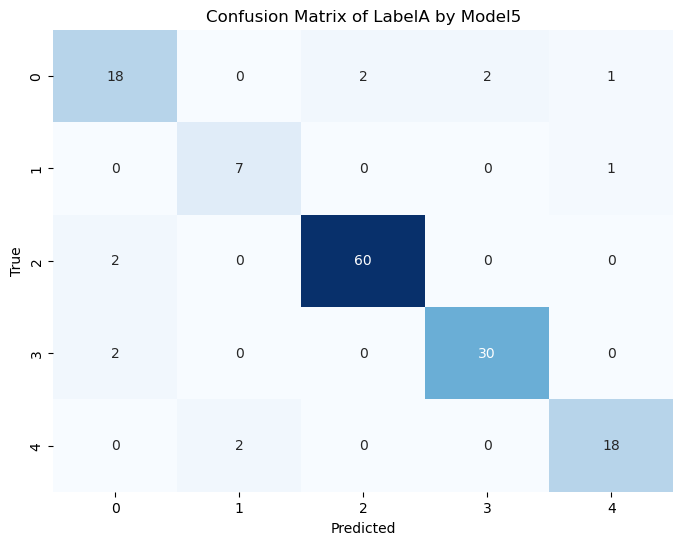

[[0.87586207 0.85713424 0.8689446  0.85719951]
 [0.82758621 0.83011352 0.77920056 0.80000605]
 [0.84827586 0.87605229 0.78326087 0.80555531]
 [0.93103448 0.92504144 0.91126578 0.91686102]
 [0.91724138 0.88024031 0.89257013 0.88575427]]


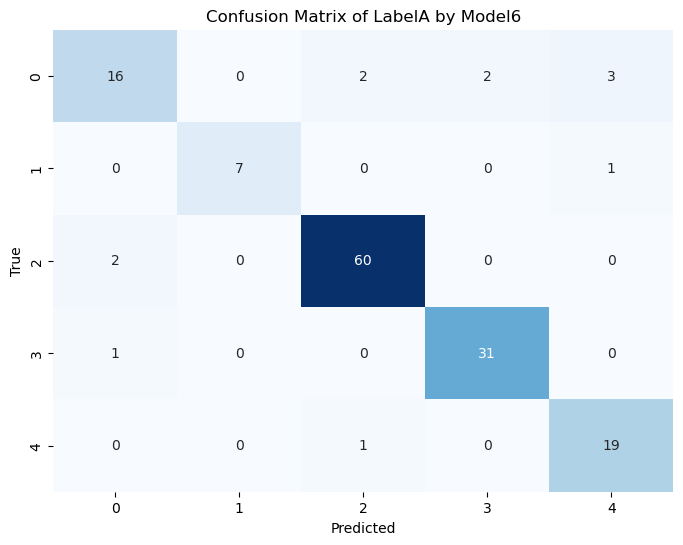

[[0.87586207 0.85713424 0.8689446  0.85719951]
 [0.82758621 0.83011352 0.77920056 0.80000605]
 [0.84827586 0.87605229 0.78326087 0.80555531]
 [0.93103448 0.92504144 0.91126578 0.91686102]
 [0.91724138 0.88024031 0.89257013 0.88575427]
 [0.91724138 0.91199342 0.89142882 0.89856104]]


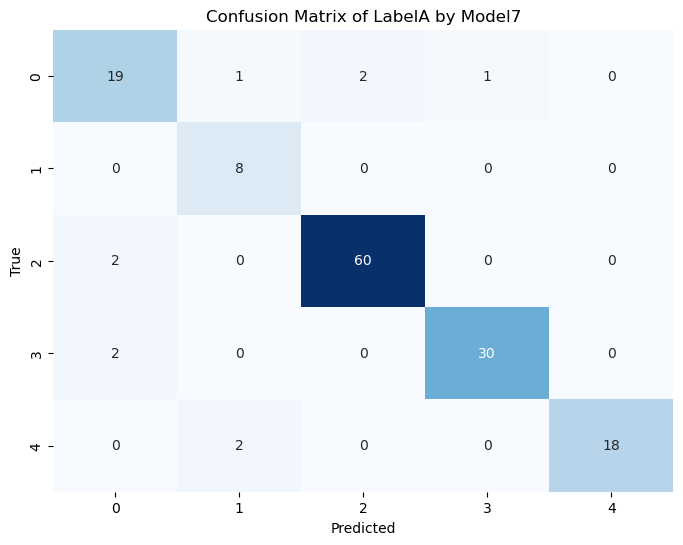

[[0.87586207 0.85713424 0.8689446  0.85719951]
 [0.82758621 0.83011352 0.77920056 0.80000605]
 [0.84827586 0.87605229 0.78326087 0.80555531]
 [0.93103448 0.92504144 0.91126578 0.91686102]
 [0.91724138 0.88024031 0.89257013 0.88575427]
 [0.91724138 0.91199342 0.89142882 0.89856104]
 [0.93103448 0.89776871 0.92626578 0.90713671]]
0.7862068965517242 0.7448275862068966 0.7517241379310344 0.7931034482758621 0.7724137902259827 0.7655172413793103 0.832


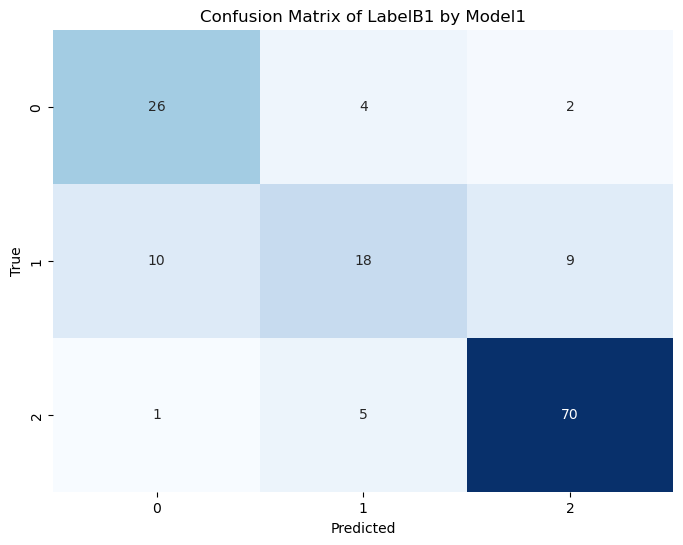

[[0.7862069  0.7445223  0.74001304 0.73594764]]


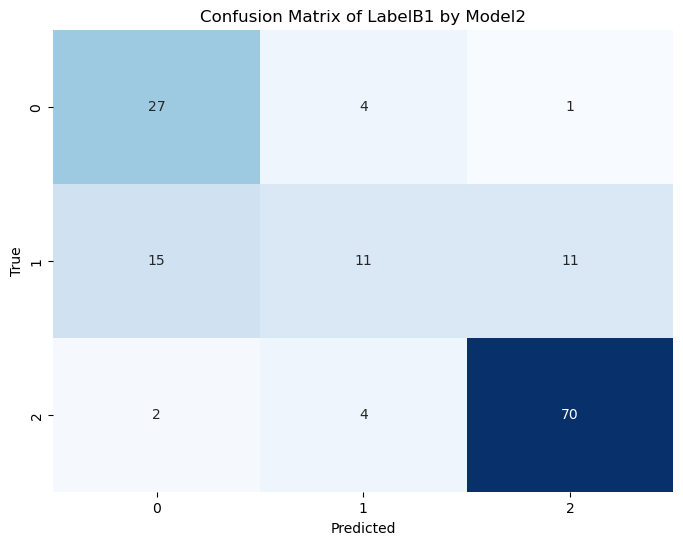

[[0.7862069  0.7445223  0.74001304 0.73594764]
 [0.74482759 0.68208076 0.68736664 0.66315314]]


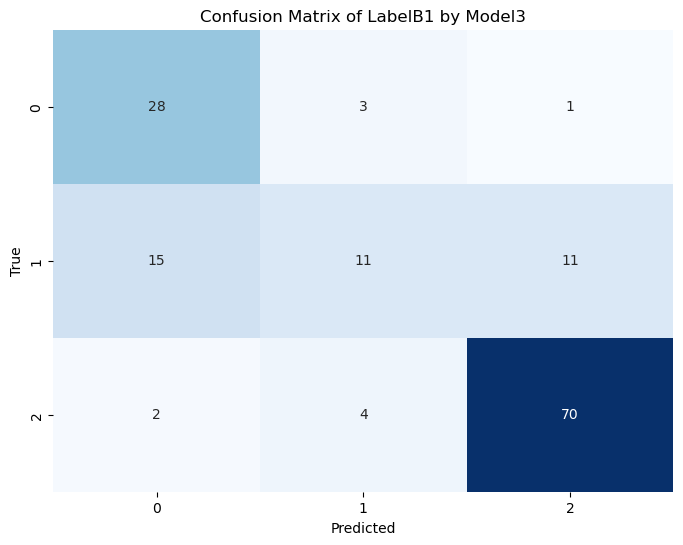

[[0.7862069  0.7445223  0.74001304 0.73594764]
 [0.74482759 0.68208076 0.68736664 0.66315314]
 [0.75172414 0.69566396 0.69778331 0.67111623]]


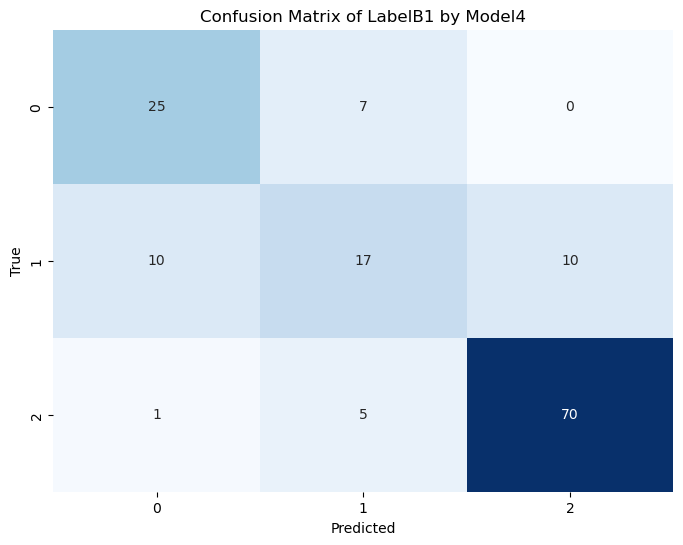

[[0.7862069  0.7445223  0.74001304 0.73594764]
 [0.74482759 0.68208076 0.68736664 0.66315314]
 [0.75172414 0.69566396 0.69778331 0.67111623]
 [0.77241379 0.71855045 0.72058736 0.71596051]]


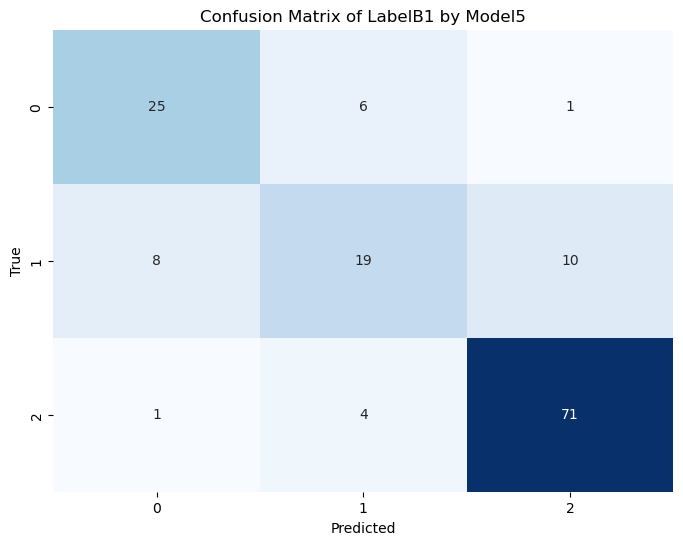

[[0.7862069  0.7445223  0.74001304 0.73594764]
 [0.74482759 0.68208076 0.68736664 0.66315314]
 [0.75172414 0.69566396 0.69778331 0.67111623]
 [0.77241379 0.71855045 0.72058736 0.71596051]
 [0.79310345 0.75210673 0.74299135 0.7440225 ]]


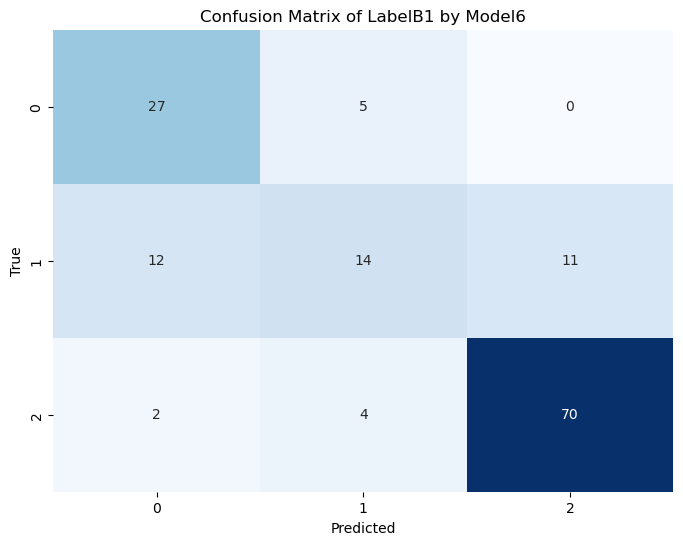

[[0.7862069  0.7445223  0.74001304 0.73594764]
 [0.74482759 0.68208076 0.68736664 0.66315314]
 [0.75172414 0.69566396 0.69778331 0.67111623]
 [0.77241379 0.71855045 0.72058736 0.71596051]
 [0.79310345 0.75210673 0.74299135 0.7440225 ]
 [0.76551724 0.71047659 0.71439367 0.69937081]]


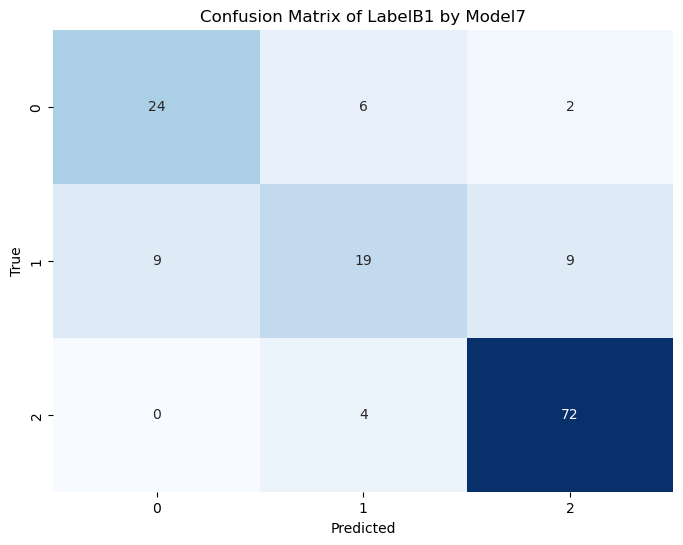

[[0.7862069  0.7445223  0.74001304 0.73594764]
 [0.74482759 0.68208076 0.68736664 0.66315314]
 [0.75172414 0.69566396 0.69778331 0.67111623]
 [0.77241379 0.71855045 0.72058736 0.71596051]
 [0.79310345 0.75210673 0.74299135 0.7440225 ]
 [0.76551724 0.71047659 0.71439367 0.69937081]
 [0.79310345 0.74997167 0.73696064 0.73995983]]
0.7310344827586207 0.7448275862068966 0.7172413793103448 0.7448275862068966 0.7793103456497192 0.7931034482758621 0.8151260504201681


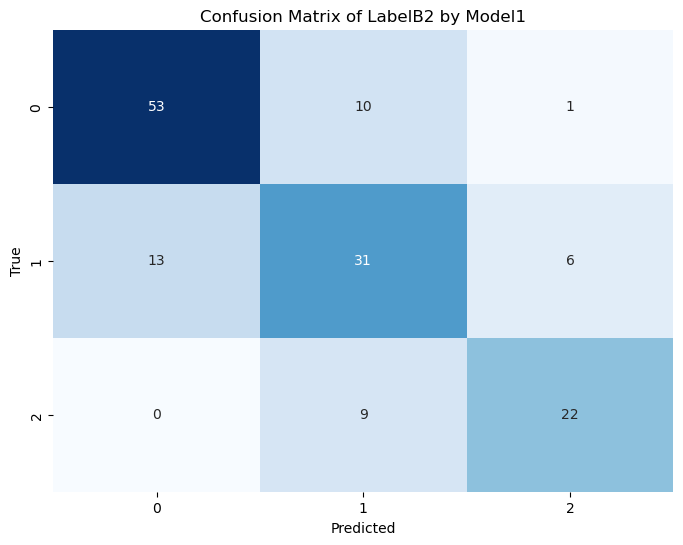

[[0.73103448 0.727217   0.71926747 0.72290598]]


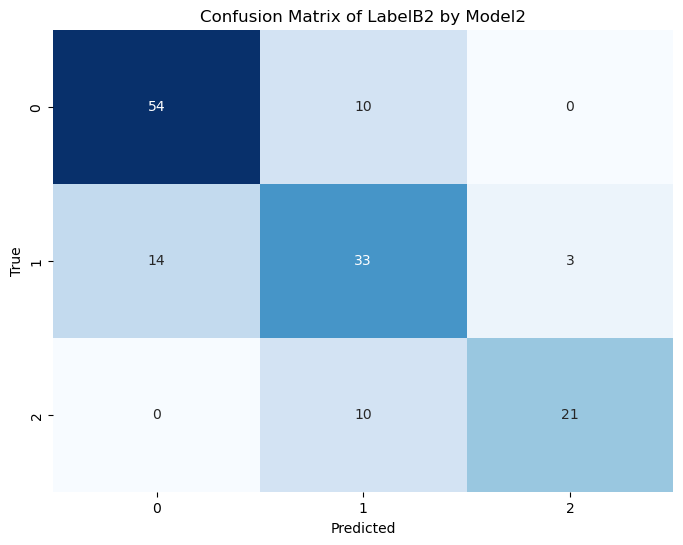

[[0.73103448 0.727217   0.71926747 0.72290598]
 [0.74482759 0.76391972 0.72705645 0.74086496]]


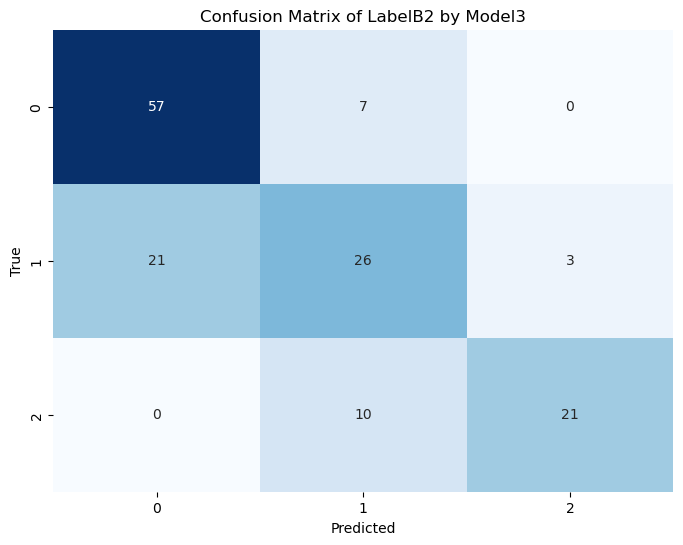

[[0.73103448 0.727217   0.71926747 0.72290598]
 [0.74482759 0.76391972 0.72705645 0.74086496]
 [0.71724138 0.7368068  0.69601478 0.70853102]]


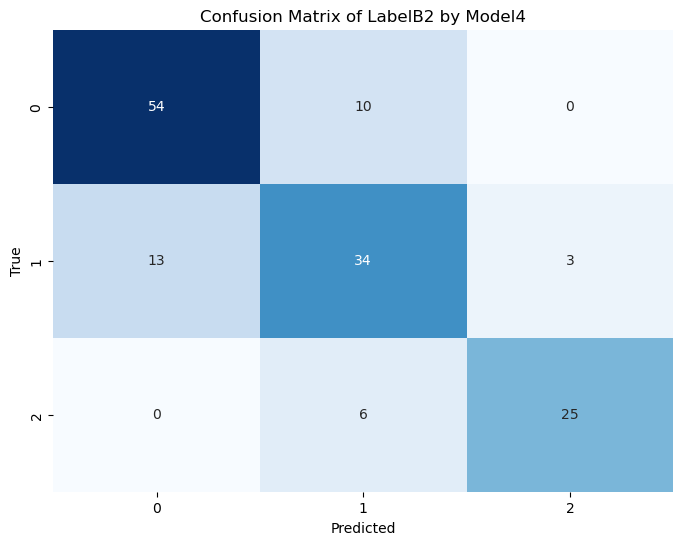

[[0.73103448 0.727217   0.71926747 0.72290598]
 [0.74482759 0.76391972 0.72705645 0.74086496]
 [0.71724138 0.7368068  0.69601478 0.70853102]
 [0.77931034 0.79294243 0.77673387 0.7839617 ]]


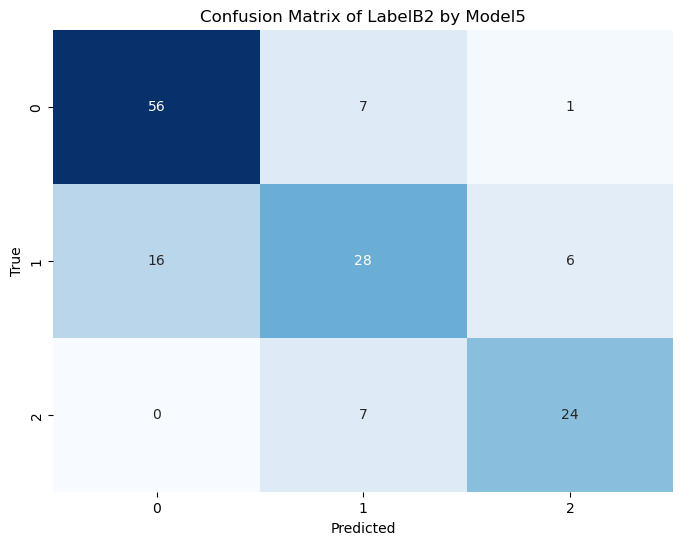

[[0.73103448 0.727217   0.71926747 0.72290598]
 [0.74482759 0.76391972 0.72705645 0.74086496]
 [0.71724138 0.7368068  0.69601478 0.70853102]
 [0.77931034 0.79294243 0.77673387 0.7839617 ]
 [0.74482759 0.739546   0.73639785 0.73547287]]


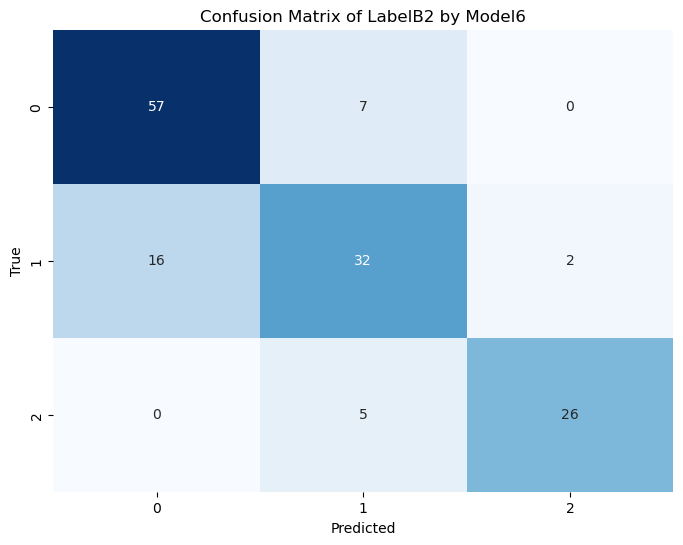

[[0.73103448 0.727217   0.71926747 0.72290598]
 [0.74482759 0.76391972 0.72705645 0.74086496]
 [0.71724138 0.7368068  0.69601478 0.70853102]
 [0.77931034 0.79294243 0.77673387 0.7839617 ]
 [0.74482759 0.739546   0.73639785 0.73547287]
 [0.79310345 0.81222202 0.78977823 0.79810793]]


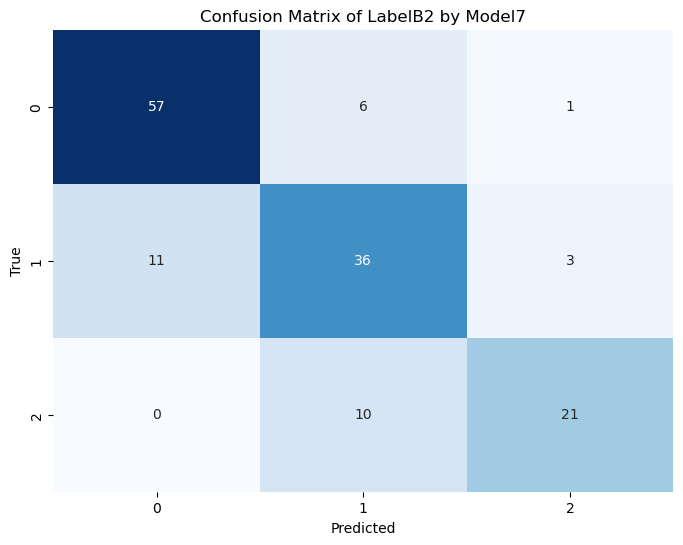

[[0.73103448 0.727217   0.71926747 0.72290598]
 [0.74482759 0.76391972 0.72705645 0.74086496]
 [0.71724138 0.7368068  0.69601478 0.70853102]
 [0.77931034 0.79294243 0.77673387 0.7839617 ]
 [0.74482759 0.739546   0.73639785 0.73547287]
 [0.79310345 0.81222202 0.78977823 0.79810793]
 [0.7862069  0.790181   0.76268145 0.77317291]]


In [ ]:
#画混淆矩阵
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # seaborn是一个可选的库，可以提供更好的图形样式
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score



split_ratio = 0.7

# 计算分割点
split_index = int(all_labeled_informations.shape[0] * split_ratio)

# 分割数组
part1 = all_labeled_informations[:split_index]
# part1[:, 6] /= part1[:, 6].mean()
part2 = all_labeled_informations[split_index:]

train_X_A = part1[:,[5, 6, 7, 9, 10, 11, 13, 14]].copy()
train_y_A = part1[:,1].copy()
train_X_B1 = part1[:,[5, 15, 16, 17, 18]].copy()
train_y_B1 = part1[:,2].copy()
train_X_B2 = part1[:,[6, 19, 20, 21, 22]].copy()
train_y_B2 = part1[:,3].copy()

test_X_A = part2[:,[5, 6, 7, 9, 10, 11, 13, 14]]
test_y_A = part2[:,1]
test_X_B1 = part2[:,[5, 15, 16, 17, 18]]
test_y_B1 = part2[:,2]
test_X_B2 = part2[:,[6, 19, 20, 21, 22]]
test_y_B2 = part2[:,3]


eva_indicators = []
for i in range(3):
    if i == 0:
        train_X, train_y, test_X, test_y = train_X_A, train_y_A, test_X_A, test_y_A
        title = 'Confusion Matrix of LabelA'
    if i == 1:
        train_X, train_y, test_X, test_y = train_X_B1, train_y_B1, test_X_B1, test_y_B1
        title = 'Confusion Matrix of LabelB1'
    if i == 2:
        train_X, train_y, test_X, test_y = train_X_B2, train_y_B2, test_X_B2, test_y_B2
        title = 'Confusion Matrix of LabelB2'

    model1, model2, model3, model4, model5 = cal(train_X, train_y, test_X, test_y, True)
    model6 = cal_xgb(train_X, train_y, test_X, test_y, True)
    res1, res2, res3, res4, res5, res6 = get_label(test_X, model1, model2, model3, model4, model5, True)
    res4, res5 = res5, res4
    res7 = get_label_xgb(test_X, model6)
    eva_indicator = np.zeros((0,4))
    # 计算混淆矩阵
    for i, res in enumerate([res1, res2, res3, res4, res5, res6, res7]):
        cm = confusion_matrix(test_y, res)
        # 使用seaborn绘制混淆矩阵
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(title + f' by Model{i+1}')
        cbar = plt.colorbar()
        plt.savefig('output/' + title + f' by Model{i+1}.png')  # 保存图像
        plt.show()

        precision = precision_score(test_y, res, average='macro')
        recall = recall_score(test_y, res, average='macro')
        f1 = f1_score(test_y, res, average='macro')
        accuracy = accuracy_score(test_y, res)
        eva_indicator = np.vstack((eva_indicator, np.array([accuracy, precision, recall, f1])))
        print(eva_indicator)
    eva_indicators.append(eva_indicator)

with pd.ExcelWriter('output.xlsx') as writer:
    sheet_names = ['labelA','labelB1', 'labelB2']
    column_names = ['准确率', '精确率', '召回率', 'F1分数']
    for i in range(3):
        index =  all_unlabeled_informations[:,23] == i
        output_indicators = pd.DataFrame(eva_indicators[i], columns=column_names)
        output_indicators.to_excel(writer, sheet_name=sheet_names[i], index=False)



In [6]:
#写入指标

split_ratio = 0.7

# 计算分割点
split_index = int(all_labeled_informations.shape[0] * split_ratio)

# 分割数组
part1 = all_labeled_informations[:split_index]
# part1[:, 6] /= part1[:, 6].mean()
part2 = all_labeled_informations[split_index:]

train_X_A = all_labeled_informations[:,[5, 6, 7, 9, 10, 11, 13, 14]].copy()
train_y_A = all_labeled_informations[:,1].copy()
train_X_B1 = all_labeled_informations[:,[5, 15, 16, 17, 18]].copy()
train_y_B1 = all_labeled_informations[:,2].copy()
train_X_B2 = all_labeled_informations[:,[6, 19, 20, 21, 22]].copy()
train_y_B2 = all_labeled_informations[:,3].copy()

test_X_A = part2[:,[5, 6, 7, 9, 10, 11, 13, 14]]
test_y_A = part2[:,1]
test_X_B1 = part2[:,[5, 15, 16, 17, 18]]
test_y_B1 = part2[:,2]
test_X_B2 = part2[:,[6, 19, 20, 21, 22]]
test_y_B2 = part2[:,3]

unlabeled_X_A = all_unlabeled_informations[:,[5, 6, 7, 9, 10, 11, 13, 14]].copy()
unlabeled_X_B1 = all_unlabeled_informations[:,[5, 15, 16, 17, 18]].copy()
unlabeled_X_B2 = all_unlabeled_informations[:,[6, 19, 20, 21, 22]].copy()

model1, model2, model3, model4, model5 = cal(train_X_A, train_y_A, test_X_A, test_y_A, True)
all_unlabeled_informations[:,1] = get_label(unlabeled_X_A, model1, model2, model3, model4, model5)

model1, model2, model3, model4, model5 = cal(train_X_B1, train_y_B1, test_X_B1, test_y_B1, True)
all_unlabeled_informations[:,2] = get_label(unlabeled_X_B1, model1, model2, model3, model4, model5)

model1, model2, model3, model4, model5 = cal(train_X_B2, train_y_B2, test_X_B2, test_y_B2, True)
all_unlabeled_informations[:,3] = get_label(unlabeled_X_B2, model1, model2, model3, model4, model5)

column_names = ['cmbh', 'Label_A', 'Label_B1', 'Label_B2', 'Label_C（无效）']
column_names += ['p1（建设用地的面积占比）', 'p2（耕地的面积占比）', 'p3（林地的面积占比）', 'p4（草地的面积占比）']
column_names += ['m1（建设用地的最大斑块指数）', 'm2（耕地的最大斑块指数）', 'm3（林地的最大斑块指数）', 'm4（草地的最大斑块指数）']
column_names += ['SHDI（香农多样性指数）', 'SHEI（香农均匀性指数）']
column_names += ['den1（建设用地的斑块数量）', 'medland1（中型建筑用地斑块的面积占比）', 'island1（小型建设用地斑块的面积占比）', 'sep1（建设用地的分离度）']
column_names += ['den2（耕地的斑块数量）', 'medland2（中型耕地斑块的面积占比）', 'island1（小型耕地斑块的面积占比）', 'sep1（耕地的分离度）']
column_names += ['水域的面积占比', '水域的最大斑块指数']
column_names += ['林地的分离度', '草地的分离度', '水域的分离度']
column_names += ['建设用地的边缘密度', '耕地的边缘密度', '林地的边缘密度', '草地的边缘密度', '水域的边缘密度']

all_unlabeled_informations = np.round(all_unlabeled_informations, 4)

with pd.ExcelWriter('output.xlsx') as writer:
    for i in range(len(excel_areas)):
        index =  all_unlabeled_informations[:,23] == i
        output_indicators = pd.DataFrame(np.hstack((all_unlabeled_informations[index,0:23], all_unlabeled_informations[index,24:])), columns=column_names)
        output_indicators.to_excel(writer, sheet_name=excel_areas[i], index=False)


1.0 0.8758620689655172 0.8482758620689655 1.0 0.9103448390960693 0.9448275862068966 1.0
1.0 0.8 0.8 1.0 0.7793103456497192 0.8206896551724138 1.0
1.0 0.8275862068965517 0.8137931034482758 1.0 0.8275862336158752 0.8620689655172413 1.0


In [ ]:
#自训练

split_ratio = 0.7

# 计算分割点
split_index = int(all_labeled_informations.shape[0] * split_ratio)

# 分割数组
part1 = all_labeled_informations[:split_index]
# part1[:, 6] /= part1[:, 6].mean()
part2 = all_labeled_informations[split_index:]

train_X_A = all_labeled_informations[:,[5, 6, 7, 9, 10, 11, 13, 14]].copy()
train_y_A = all_labeled_informations[:,1].copy()
train_X_B1 = all_labeled_informations[:,[5, 15, 16, 17, 18]].copy()
train_y_B1 = all_labeled_informations[:,2].copy()
train_X_B2 = all_labeled_informations[:,[6, 19, 20, 21, 22]].copy()
train_y_B2 = all_labeled_informations[:,3].copy()

test_X_A = part2[:,[5, 6, 7, 9, 10, 11, 13, 14]]
test_y_A = part2[:,1]
test_X_B1 = part2[:,[5, 15, 16, 17, 18]]
test_y_B1 = part2[:,2]
test_X_B2 = part2[:,[6, 19, 20, 21, 22]]
test_y_B2 = part2[:,3]

unlabeled_X_A = all_unlabeled_informations[:,[5, 6, 7, 9, 10, 11, 13, 14]].copy()
unlabeled_X_B1 = all_unlabeled_informations[:,[5, 15, 16, 17, 18]].copy()
unlabeled_X_B2 = all_unlabeled_informations[:,[6, 19, 20, 21, 22]].copy()

for i in range(0, 10):
    print(train_X_A.shape, train_y_A.shape, unlabeled_X_A.shape)
    decision_tree, svc, logistic_regression, random_forest, model = cal(train_X_A, train_y_A, test_X_A, test_y_A, True)
    unlabeled_X_tensor = torch.tensor(unlabeled_X_A, dtype=torch.float32)
    # 禁用梯度计算，以减少计算量
    with torch.no_grad():
        # 对测试集进行预测
        outputs = model(unlabeled_X_tensor)
        # 获取预测结果的最大值所在的位置，即预测的类别
        prediction_label5_tensor = outputs.argmax(dim=1)
    probability_distribution = softmax(outputs.numpy())
    confidence_level = np.max(probability_distribution, axis=1)
    index = (confidence_level > 0.9999)
    train_X_A = np.vstack((train_X_A, unlabeled_X_A[index]))
    train_y_A = np.concatenate((train_y_A, prediction_label5_tensor.numpy()[index] + 1))
    unlabeled_X_A = np.delete(unlabeled_X_A, index, axis=0)

(483, 8) (483,) (13256, 8)
1.0 0.8413793103448276 0.8137931034482758 1.0 0.8482758402824402 0.8758620689655172 1.0
(821, 8) (821,) (12918, 8)
1.0 0.8482758620689655 0.8206896551724138 1.0 0.8482758402824402 0.8689655172413793 1.0
(835, 8) (835,) (12904, 8)
1.0 0.8482758620689655 0.8206896551724138 1.0 0.8689655065536499 0.8758620689655172 1.0
(1998, 8) (1998,) (11741, 8)
1.0 0.8482758620689655 0.8137931034482758 1.0 0.8482758402824402 0.8620689655172413 1.0
(2035, 8) (2035,) (11704, 8)
1.0 0.8482758620689655 0.8206896551724138 1.0 0.8551723957061768 0.8758620689655172 1.0
(2129, 8) (2129,) (11610, 8)
1.0 0.8482758620689655 0.8275862068965517 1.0 0.8551723957061768 0.8758620689655172 1.0
(2129, 8) (2129,) (11610, 8)
1.0 0.8482758620689655 0.8275862068965517 1.0 0.8551723957061768 0.8827586206896552 1.0
(2131, 8) (2131,) (11608, 8)
1.0 0.8482758620689655 0.8275862068965517 1.0 0.8620689511299133 0.8827586206896552 1.0
(2131, 8) (2131,) (11608, 8)
1.0 0.8482758620689655 0.8275862068965517

In [191]:
diff_result = diffsion(all_unlabeled_informations, all_edges)

扩散次数： 10605
